## Bayesian vs freq

#### Interesting links 

- http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/

- http://blog.applied.ai/bayesian-inference-with-pymc3-part-1/

- Noninformative prior: https://normaldeviate.wordpress.com/2013/07/13/lost-causes-in-statistics-ii-noninformative-priors/comment-page-1/

### Summary

- Frequentist: Probabilities are fundamentaly related to frequencies of events.

- Bayesian: Probabilities are fundamentaly related to our own knowledge about an event.


# Simple Photon Counts


Imagine that we point our telescope to the sky, and observe the light coming from a single star. For the time being, we'll assume that the star's true flux is constant with time, i.e. that is it has a fixed value $F_{true}$ (we'll also ignore effects like sky noise and other sources of systematic error). We'll assume that we perform a series of $N$ measurements with our telescope, where the ith measurement reports the observed photon flux $F_i$ and error $e_i$.

 - **The question is, given this set of measurements $D=\{F_i,e_i\}$, what is our best estimate of the true flux $F_{true}$ ?**

In [1]:
# Generating some simple photon count data
import numpy as np
from scipy import stats
np.random.seed(1)  # for repeatability

F_true = 1000  # true flux, say number of photons measured in 1 second
N = 50 # number of measurements
F = stats.poisson(F_true).rvs(N)  # N measurements of the flux
e = np.sqrt(F)  # errors on Poisson counts estimated via square root

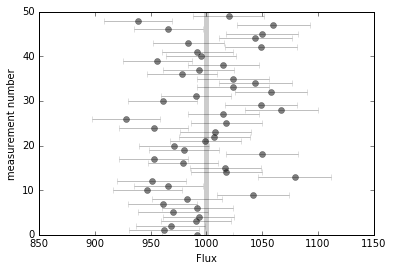

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux");ax.set_ylabel("measurement number");

These measurements each have a different error $e_i$ which is estimated from Poisson statistics using the standard square-root rule. In this toy example we already know the true flux $F_{true}$, but the question is this: 

- **given our measurements and errors, what is our best estimate of the true flux?**

## Frequentist approach to simple photon counts


We can start by the classical MLE approach. Given a single observation $D_i = \{F_i, e_i\}$ we can compute the probability distribution of the measurement given the true flux $F_{true}$ given our assumption of Gaussian errors. That is we are assuming that the probability of $D_i$ given $F_{true}$ is a normal distribution with mean $F_{true}$ and standard deviation $e_i$.

\begin{equation}
P(D_i \mid F_{true} ) = \frac{1}{\sqrt{2 \pi e_i^2}} \exp{\left[  \frac{  - (F_i - F_{true})^2}{2 e_i^2}  \right]}
\end{equation}

In [12]:
w = 1. / e ** 2

MLE_photon_counts = (w * F).sum() / w.sum()

print("""
      F_true = {0}
      F_est  = {1:.0f} +/- {2:.0f} (based on {3} measurements)
      """.format(F_true, MLE_photon_counts, w.sum() ** -0.5, N))


      F_true = 1000
      F_est  = 998 +/- 4 (based on 50 measurements)
      


## Bayesian aproach to simple photon counts

The Bayesian approach, as you might expect, begins and ends with probabilities. It recognizes that what we fundamentally want to compute is our knowledge of the parameters in question, i.e. in this case,

$$
P(F_{true} \mid D)
$$

**this formulation of the problem is fundamentally contrary to the frequentist philosophy**, which says that probabilities have no meaning for model parameters like $F_true$. Nevertheless, within the Bayesian philosophy this is perfectly acceptable.

\begin{equation}
P(F_{true} \mid D) = \frac{P(D \mid F_{true}) P(F_{true})}{P(D)}
\end{equation}

Though Bayes' theorem is where Bayesians get their name, it is not this law itself that is controversial, but the Bayesian interpretation of probability implied by the term $P(F_{true} \mid D)$.


- $P(F_{true} \mid D)$: The posterior, or the probability of the model parameters given the data: this is the result we want to compute.


- $P(D \mid F_{true})$: The likelihood, which is proportional to the $\mathcal{L}(D \mid F_{true})$ in the frequentist approach, above.


- $P(F_{true})$: The model prior, which encodes what we knew about the model prior to the application of the data $D$.


- $P(D)$: The data probability, which in practice amounts to simply a normalization term.

If we set $ P(F_{true}) \propto 1$ (uniform or flat prior) we find

$$
P(F_{true} \mid D) \propto \mathcal{L}(D \mid F_{true})
$$
and the Bayesian probability is maximized at precisely the same value as the frequentist result! So despite the philosophical differences, we see that (for this simple problem at least) the Bayesian and frequentist point estimates are equivalent.

### Choosing the prior $P(F_{true})$

#### Philosophical debate
A frequentist will point out that the prior is problematic when no true prior information is available. Though it might seem straightforward to use a noninformative prior like the flat prior mentioned above, there are some surprisingly subtleties involved. It turns out that in many situations, a truly noninformative prior does not exist! Frequentists point out that the subjective choice of a prior which necessarily biases your result has no place in statistical data analysis.

A Bayesian would counter that frequentism doesn't solve this problem, but simply skirts the question. Frequentism can often be viewed as simply a special case of the Bayesian approach for some (implicit) choice of the prior: a Bayesian would say that it's better to make this implicit choice explicit, even if the choice might include some subjectivity.

#### Bayesian computations

Let's address how Bayesian results are generally computed in practice. For a one parameter problem like the one considered here, it's as simple as computing the posterior probability $P(F_{true} \mid D)$ as a function of $F_{true}$: this is  the distribution reflecting our knowledge of the parameter $F_{true}$. As the dimension of the model grows, this direct approach becomes increasingly intractable. For this reason, Bayesian calculations often depend on sampling methods such as Markov Chain Monte Carlo (MCMC).

I won't go into the details of the theory of MCMC here. Instead I'll show a practical example of applying an MCMC approach using Dan Foreman-Mackey's excellent **```emcee```** package. Keep in mind here that the goal is to generate a set of points drawn from the posterior probability distribution, and to use those points to determine the answer we seek.


To perform this MCMC, we start by defining Python functions for the
- prior $P(F_{true})$
- the likelihood $P(D \mid F_{true})$
- the posterior $P(Ftrue \mid D)$, 

noting that none of these need be properly normalized. Our model here is one-dimensional, but to handle multi-dimensional models we'll define the model in terms of an array of parameters $\theta$, which in this case is $θ=[F_{true}]$:

In [13]:
def log_prior(theta):
    return 1  # flat prior

def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2)
                         + (F - theta[0]) ** 2 / e ** 2)

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)



Now we set up the problem, including generating some random starting guesses for the multiple chains of points.


In [14]:
ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
starting_guesses = 2000 * np.random.rand(nwalkers, ndim)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

If this all worked correctly, the array sample should contain a series of 50000 points drawn from the posterior. Let's plot them and check:

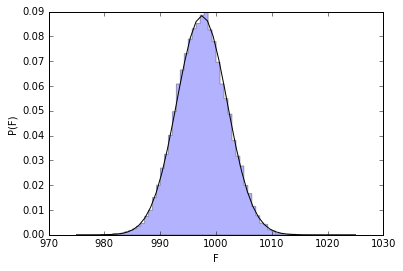

In [15]:
# plot a histogram of the sample
plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.3, normed=True)

# plot a best-fit Gaussian
F_fit = np.linspace(975, 1025)
pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)

plt.plot(F_fit, pdf, '-k')
plt.xlabel("F"); plt.ylabel("P(F)")



We end up with a sample of points drawn from the (normal) posterior distribution. The mean and standard deviation of this posterior are the corollary of the frequentist maximum likelihood estimate above:


In [16]:
print("""
      F_true = {0}
      F_est  = {1:.0f} +/- {2:.0f} (based on {3} measurements)
      """.format(F_true, np.mean(sample), np.std(sample), N))


      F_true = 1000
      F_est  = 997 +/- 5 (based on 50 measurements)
      




We see that as expected for this simple problem, the Bayesian approach yields the same result as the frequentist approach!


#### About the results



Now, you might come away with the impression that the Bayesian method is unnecessarily complicated, and in this case it certainly is. Using an Affine Invariant Markov Chain Monte Carlo Ensemble sampler to characterize a one-dimensional normal distribution is a bit like using the Death Star to destroy a beach ball, but I did this here because it demonstrates an approach that can scale to complicated posteriors in many, many dimensions, and can provide nice results in more complicated situations where an analytic likelihood approach is not possible.

As a side note, you might also have noticed one little sleight of hand: at the end, we use a frequentist approach to characterize our posterior samples! When we computed the sample mean and standard deviation above, we were employing a distinctly frequentist technique to characterize the posterior distribution. The pure Bayesian result for a problem like this would be to report the posterior distribution itself (i.e. its representative sample), and leave it at that. That is, in pure Bayesianism the answer to a question is not a single number with error bars; the answer is the posterior distribution over the model parameters!


# Confidence

- See: https://arxiv.org/pdf/1411.5018v1.pdf
- Confidence interval vs Credible region http://stats.stackexchange.com/questions/2272/whats-the-difference-between-a-confidence-interval-and-a-credible-interval

When trying to estimate the value of an unknown parameter, the frequentist approach generally relies on a confidence interval (CI), while the Bayesian approach relies on a credible region (CR). While these concepts sound and look very similar, their subtle difference can be extremely important, as they answer essentially different questions.

speaking broadly: 
- **frequentists consider model parameters to be fixed and data to be random**
- **Bayesians consider model parameters to be random and data to be fixed**.

These philosophies fundamenally affect the way that each approach seeks bounds on the value of a model parameter. Because the differences here are subtle, I'll go right into a simple example to illustrate the difference between a frequentist confidence interval and a Bayesian credible region.